## Head

In [7]:
import os 

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')


Project path set to: c:\Github\ode-biomarker-project


In [8]:
import toolkit as tl 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set the seaborn theme
sns.set_theme(style="whitegrid")
# set to talk 
sns.set_context("talk")

In [9]:
### Load data

import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)

# open the cache for neighbourhood calculations

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'rb') as f:
    nth_degree_neighbours = pickle.load(f)


In [10]:
import DataFunctions as utils 

target_variable = "LN_IC50"

data_df = utils.create_joint_dataset_from_proteome_gdsc("Palbociclib", joined_sin_peptile_exclusion_matrix, gdsc2, drug_value=target_variable)
feature_data, label_data = utils.create_feature_and_label(data_df, label_name=target_variable)

## Testing

In [5]:
### Record SHAP values for network stat features

tool = tl.Toolkit(feature_data=feature_data, label_data=label_data)

tool.add_condition('network_stat',
                True,
                tl.impute_with_network_stat_selection,
                (nth_degree_neighbours, 2, 100))

tool.add_model('ElasticNet',
            'ElasticNet', 
            {'alpha': 0.005, 'max_iter': 10000})

rng_list = np.random.randint(0, 100000, 5)
tool.set_rng_list(rng_list)

shap_df = tool.run_all(n_jobs=2, verbose=True)

shap_contribs = tl.get_mean_contribution(shap_df, 'network_stat')

### All models ran


In [6]:
shap_contribs.head()

,mean_shap_values,count
feature_names,,
Q14566;MCM6_HUMAN,0.359695,5
P50991;TCPD_HUMAN,0.349384,5
P49736;MCM2_HUMAN,0.315420,5
P49321;NASP_HUMAN,0.311145,5
P49368;TCPG_HUMAN,0.309466,5


In [7]:
# modify the column name 'mean_shap_values' to 'fold_1'

shap_contribs = shap_contribs.rename(columns={'mean_shap_values': 'fold_1'})

In [8]:
shap_contribs.head()

,fold_1,count
feature_names,,
Q14566;MCM6_HUMAN,0.359695,5
P50991;TCPD_HUMAN,0.349384,5
P49736;MCM2_HUMAN,0.315420,5
P49321;NASP_HUMAN,0.311145,5
P49368;TCPG_HUMAN,0.309466,5


In [9]:
# remove the column 'count' 

shap_contribs = shap_contribs.drop(columns=['count'])

In [10]:
shap_contribs.head()


,fold_1
feature_names,
Q14566;MCM6_HUMAN,0.359695
P50991;TCPD_HUMAN,0.349384
P49736;MCM2_HUMAN,0.315420
P49321;NASP_HUMAN,0.311145
P49368;TCPG_HUMAN,0.309466


In [11]:
shap_contribs_2 = shap_contribs.copy()
shap_contribs_2.head()

,fold_1
feature_names,
Q14566;MCM6_HUMAN,0.359695
P50991;TCPD_HUMAN,0.349384
P49736;MCM2_HUMAN,0.315420
P49321;NASP_HUMAN,0.311145
P49368;TCPG_HUMAN,0.309466


In [12]:
shap_contribs_2 = shap_contribs_2.rename(columns={'fold_1': 'fold_2'})


In [13]:
shap_contribs_2.head()

,fold_2
feature_names,
Q14566;MCM6_HUMAN,0.359695
P50991;TCPD_HUMAN,0.349384
P49736;MCM2_HUMAN,0.315420
P49321;NASP_HUMAN,0.311145
P49368;TCPG_HUMAN,0.309466


In [14]:
# combine the two dataframes

shap_contribs_all = pd.concat([shap_contribs, shap_contribs_2], axis=1)

shap_contribs_all.head()

,fold_1,fold_2
feature_names,,
Q14566;MCM6_HUMAN,0.359695,0.359695
P50991;TCPD_HUMAN,0.349384,0.349384
P49736;MCM2_HUMAN,0.315420,0.315420
P49321;NASP_HUMAN,0.311145,0.311145
P49368;TCPG_HUMAN,0.309466,0.309466


In [15]:
shap_contribs_3 = shap_contribs.copy()
shap_contribs_3 = shap_contribs_3.rename(columns={'fold_1': 'fold_3'})

shap_contribs_3.head()

,fold_3
feature_names,
Q14566;MCM6_HUMAN,0.359695
P50991;TCPD_HUMAN,0.349384
P49736;MCM2_HUMAN,0.315420
P49321;NASP_HUMAN,0.311145
P49368;TCPG_HUMAN,0.309466


In [16]:
# drop a random row in shap_contribs_3

shap_contribs_3 = shap_contribs_3.drop(shap_contribs_3.sample().index)

shap_contribs_3.head()

,fold_3
feature_names,
Q14566;MCM6_HUMAN,0.359695
P49736;MCM2_HUMAN,0.315420
P49321;NASP_HUMAN,0.311145
P49368;TCPG_HUMAN,0.309466
P40227;TCPZ_HUMAN,0.258876


In [17]:
# combine the two dataframes

shap_contribs_all = pd.concat([shap_contribs_all, shap_contribs_3], axis=1)

shap_contribs_all.head()

,fold_1,fold_2,fold_3
feature_names,,,
Q14566;MCM6_HUMAN,0.359695,0.359695,0.359695
P50991;TCPD_HUMAN,0.349384,0.349384,NaN
P49736;MCM2_HUMAN,0.315420,0.315420,0.315420
P49321;NASP_HUMAN,0.311145,0.311145,0.311145
P49368;TCPG_HUMAN,0.309466,0.309466,0.309466


## Consensus Functions

In [11]:
### Record SHAP values for network stat features

tool = tl.Toolkit(feature_data=feature_data, label_data=label_data)

tool.add_condition('network_stat',
                True,
                tl.impute_with_network_stat_selection,
                (nth_degree_neighbours, 2, 100))

tool.add_model('MLPRegressor',
            'MLPRegressor', 
            {'hidden_layer_sizes': (16, 16, 16), 'max_iter': 10000})

In [12]:
rng_list, total_df, meta_results = tool.run_until_consensus('network_stat', n_jobs=1, verbose=True, max_iter=50, return_meta_df=True)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
100%|██████████| 74/74 [00:14<00:00,  5.14it/s]
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


current_contrib: ['P06400;RB_HUMAN', 'Q92608;DOCK2_HUMAN', 'P32519;ELF1_HUMAN', 'P42768;WASP_HUMAN', 'Q07817;B2CL1_HUMAN']
current iteration: 2 current_tol: 0.297711, abs_diff: 1.667071, abs_prev: 5.599628, corr: 0.489545


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
100%|██████████| 74/74 [00:14<00:00,  5.11it/s]


current_contrib: ['P06400;RB_HUMAN', 'P32519;ELF1_HUMAN', 'Q92608;DOCK2_HUMAN', 'P02545;LMNA_HUMAN', 'Q07817;B2CL1_HUMAN']
current iteration: 3 current_tol: 0.165225, abs_diff: 1.162958, abs_prev: 7.038613, corr: 0.683976


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
100%|██████████| 74/74 [00:14<00:00,  5.11it/s]


current_contrib: ['P06400;RB_HUMAN', 'P32519;ELF1_HUMAN', 'Q07817;B2CL1_HUMAN', 'Q92608;DOCK2_HUMAN', 'Q14161;GIT2_HUMAN']
current iteration: 4 current_tol: 0.095493, abs_diff: 0.752567, abs_prev: 7.880820, corr: 0.456789


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
100%|██████████| 74/74 [00:14<00:00,  5.16it/s]


current_contrib: ['P06400;RB_HUMAN', 'P32519;ELF1_HUMAN', 'Q92608;DOCK2_HUMAN', 'Q07817;B2CL1_HUMAN', 'P27707;DCK_HUMAN']
current iteration: 5 current_tol: 0.069322, abs_diff: 0.583061, abs_prev: 8.410953, corr: 0.590485


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 35%|███▌      | 26/74 [00:05<00:09,  5.09it/s]

 43%|████▎     | 32/74 [00:06<00:08,  4.79it/s]

In [ ]:
data = []

for i in range(len(rng_list)):
    mean_contribution = tl.get_mean_contribution(total_df.iloc[:i+1], 'network_stat', strict_mean=0.75)
    mean_contribution = mean_contribution.rename(columns={'mean_shap_values': f'{i+1}'})
    mean_contribution = mean_contribution.drop(columns=['count'])
    data.append(mean_contribution)

shap_contribs_all = pd.concat(data, axis=1)

shap_contribs_all.head()


,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
feature_names,,,,,,,,,,,,,,,,,,,,,
Q14566;MCM6_HUMAN,0.446382,0.350870,0.326088,0.338592,0.328998,0.347919,0.357581,0.364833,0.365897,0.359401,...,0.387841,0.385131,0.388876,0.385052,0.382124,0.369443,0.365696,0.364009,0.362614,0.360321
P50991;TCPD_HUMAN,0.373990,0.406925,0.363454,0.385345,0.377623,0.359986,0.357832,0.346022,0.360558,0.356198,...,0.360901,0.366312,0.370338,0.375757,0.368775,0.367952,0.363250,0.370816,0.372374,0.367137
P49736;MCM2_HUMAN,0.371444,0.378360,0.348057,0.359783,0.332374,0.338921,0.341998,0.347099,0.358860,0.347245,...,0.341451,0.342931,0.342213,0.337082,0.337810,0.335882,0.335074,0.344621,0.340522,0.339954
P49321;NASP_HUMAN,0.291575,0.267013,0.278494,0.266539,0.277525,0.283067,0.284291,0.280492,0.281136,0.290359,...,0.297842,0.295354,0.294228,0.294630,0.292667,0.294413,0.294340,0.297246,0.298106,0.296084
P33991;MCM4_HUMAN,0.245624,0.198601,0.184998,0.192410,0.192334,0.197708,0.202913,0.204263,0.203098,0.202966,...,0.223908,0.223111,0.229213,0.226056,0.218456,0.210878,0.210123,0.202041,0.201207,0.198285


In [ ]:
# sort shap_contribs_all descending order by last column

shap_contribs_all_sorted = shap_contribs_all.sort_values(by=shap_contribs_all.columns[-1], ascending=False)

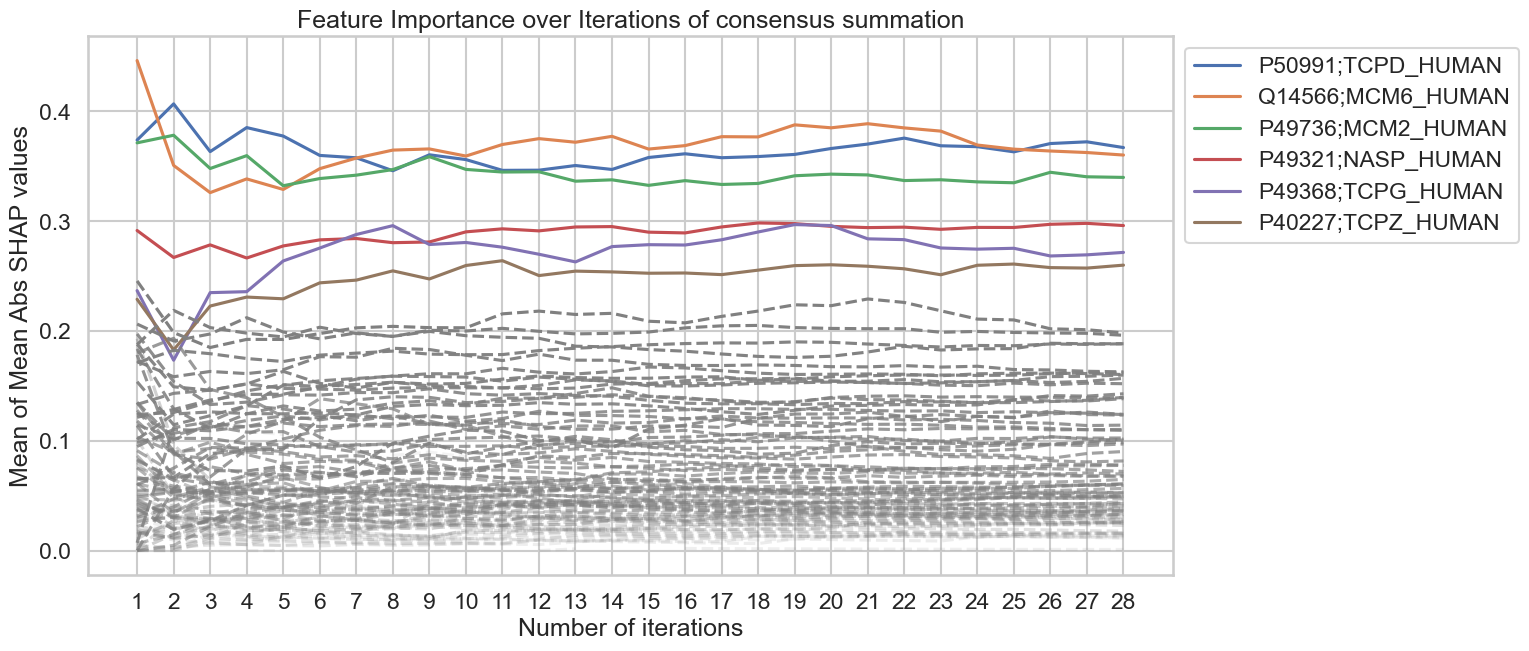

In [ ]:
# plot each row as a line plot

fig, ax = plt.subplots(figsize=(14, 7))

significant_display = 6

for i in range(significant_display):
    ax.plot(shap_contribs_all_sorted.iloc[i, :])
    
for i in range(significant_display, len(shap_contribs_all_sorted)):
    alpha_ratio = (i - significant_display) / (len(shap_contribs_all_sorted) - significant_display)
    ax.plot(shap_contribs_all_sorted.iloc[i, :], linestyle='dashed', alpha=1-alpha_ratio, color='grey')
    
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Mean of Mean Abs SHAP values')
ax.set_title('Feature Importance over Iterations of consensus summation')
ax.legend(shap_contribs_all_sorted.index[:significant_display], loc='upper right', bbox_to_anchor=(1.33, 1))

plt.show()

In [ ]:
# save the figure

filepath = 'data/processed-results/consensus'

fig.savefig(f'{filepath}/consensus_summation.png', dpi=300, bbox_inches='tight')

# save the dataframe to csv

shap_contribs_all_sorted.to_csv(f'{filepath}/consensus_summation.csv')

# pickle rng_list, total_df, meta_results from tool

with open(f'{filepath}/consensus_summation.pkl', 'wb') as f:
    pickle.dump(rng_list, f)
    pickle.dump(total_df, f)
    pickle.dump(meta_results, f)